# Import pkg

In [80]:
import numpy as np
import pandas as pd
from numpy import genfromtxt
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Import datasets

In [81]:
train = pd.read_csv('tr_server_data.csv', header = None, names = ['latency', 'throughput'])

In [82]:
train.head()

,latency,throughput
0,13.047,14.741
1,13.409,13.763
2,14.196,15.853
3,14.915,16.174
4,13.577,14.043


In [83]:
cross_val = pd.read_csv('cv_server_data.csv', header= None, names = ['latency', 'throughput'])

In [84]:
cross_val.head()

,latency,throughput
0,15.790,14.921
1,13.640,15.330
2,14.866,16.474
3,13.585,13.989
4,13.464,15.635


In [85]:
grnd_trth = pd.read_csv('gt_server_data.csv', header= None, names = ['ground_truth'])

In [86]:
grnd_trth.head()

,ground_truth
0,0
1,0
2,0
3,0
4,0


# Data size

In [87]:
train.shape, cross_val.shape, grnd_trth.shape

((307, 2), (307, 2), (307, 1))

# EDA

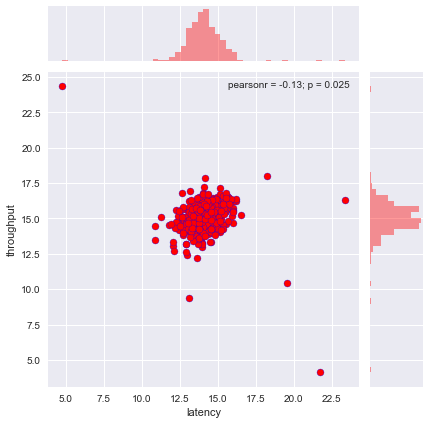

In [88]:
sns.jointplot(train.latency, train.throughput, color = 'r', edgecolor = 'b')

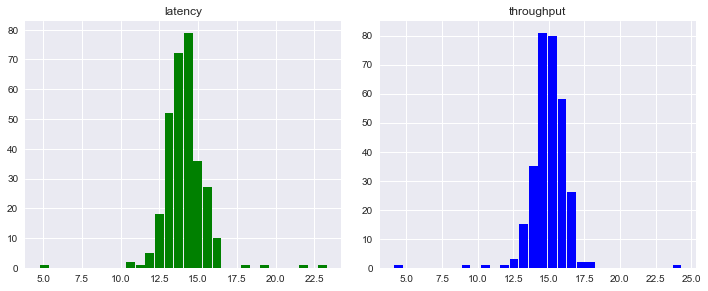

In [89]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize = (10,4))

### To get rid of overlap:
plt.tight_layout()
axes[0].hist(train.latency, bins = 30, rwidth=0.92, color='g')
axes[0].set_title("latency")

axes[1].hist(train.throughput, bins = 30, rwidth=0.92, color='b')
axes[1].set_title("throughput")


# standardize data

In [72]:
# scaler = StandardScaler()
# train = scaler.fit_transform(train)

# Cal mu and $sigma squared$ for the probability density function

In [103]:
mu = train.mean()
sigma_square = np.cov(train.T) #### Covariance matrix for sigma**2 ....P(xi: mu, sigma**2)

print('mu:' + str(mu), 'var:' + str(sigma_square))

mu:latency       14.112253
throughput    14.997675
dtype: float64 var:[[ 1.83866684 -0.22783493]
 [-0.22783493  1.71530264]]


# Create a multivariate normal (Gaussian) random variable 
> inputs: train dataset as array, mu as array and covariance matrix



In [120]:
mv_gaussian = multivariate_normal(mu, sigma_square) #### Instantiate the random variable using mu and cov mat of train

## Calculate probabilities using the traindata based mv_norm object and CV dataset

In [204]:
pdf = mv_gaussian.pdf(cross_val)
type(pdf), pdf.shape

(numpy.ndarray, (307,))

# Plot the pdf for train data set

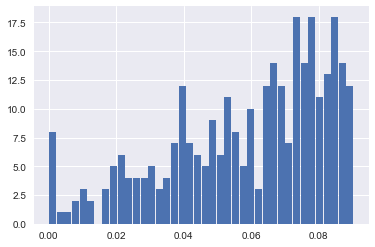

In [122]:
#plt.plot(np.sort(p_cv)), len(p_cv)
plt.hist(pdf, bins = 40, rwidth = 0.92)
plt.show()


# CDF of probabilities

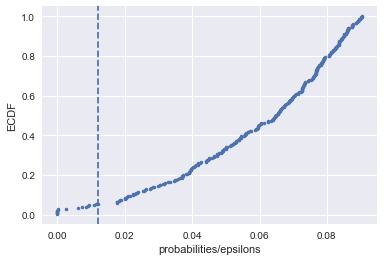

In [123]:
x = np.sort(pdf)
y = np.arange(1, (len(pdf)+1))/len(pdf)
plt.plot(x,y,marker = '.', linestyle = 'none')
plt.xlabel('probabilities/epsilons')
plt.ylabel('ECDF')
plt.axvline(x = 0.012, linestyle = '--')

# Select the epsilon and make predictions on CV data to calc f1 score
> if f score is high that means both precision and recall are high which indicates a good model

In [183]:
def best_epsilon(P, groundTruth):
#     P = np.array(P)
#     groundTruth = np.array(groundTruth)
    best_eps = 0 
    best_score = 0
    step = (max(P) - min(P))/500
    epsln = np.arange(min(P), max(P), step)
    for eps in np.nditer(epsln):
        pred = P < eps
        f1s = f1_score(groundTruth, pred, average = 'binary')
        if f1s > best_score:
            best_score = f1s
            best_eps = eps
            
    return best_eps, best_score 

## Lets calculate the best epsilon for multivariate gaussian outlier classification

In [187]:
final_epsilon, best_f1_score = best_epsilon(pdf, grnd_trth['ground_truth'])

/Users/admin/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [188]:
final_epsilon

array(0.00018072402655962432)

# Use the best epsilon to determine outliers:
> probabilities < epsilon are outliers

In [243]:
#selecting outlier datapoints 
outliers = np.where(pdf < final_epsilon)
outliers[0]


array([300, 301, 302, 303, 304, 305, 306])

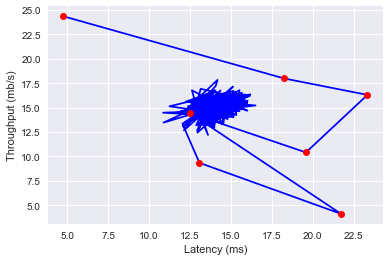

In [244]:
plt.figure()

plt.plot(train.iloc[:,0],train.iloc[:,1],marker = 'x', color = 'b')
plt.plot(train.iloc[[300, 301, 302, 303, 304, 305, 306],0],train.iloc[[300, 301, 302, 303, 304, 305, 306],1],'ro')

plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')

plt.show()

## Anomaly Detection Using One-Class SVM

In [245]:
from sklearn import svm

In [246]:
# use the same dataset
tr_data = read_dataset('tr_server_data.csv')

In [247]:
clf = svm.OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1)
clf.fit(tr_data)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
      max_iter=-1, nu=0.05, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [248]:
pred = clf.predict(tr_data)

# inliers are labeled 1, outliers are labeled -1
normal = tr_data[pred == 1]
abnormal = tr_data[pred == -1]

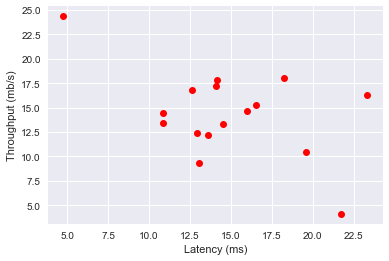

In [249]:
plt.figure()
plt.plot(normal[:,0],normal[:,1],'bx')
plt.plot(abnormal[:,0],abnormal[:,1],'ro')
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()